# Run basic analyses on PharaGlow datasets

In [ ]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import shutil
import timeit
from datetime import date
import csv

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
import pharaglow
from pharaglow import tracking, run, features, util, io, extract

In [2]:
def run_behavior_extraction(traj, fps = 30):
    """Extract velocity, pumping events, reversals from raw tracks."""
    traj = extract.calculate_time(traj, fps)
    traj = extract.calculate_locations(traj, scale)
    traj = extract.calculate_velocity(traj, scale, fps, dt = 1)
    traj = extract.preprocess_signal(traj, key='pumps', w_outlier=300, w_bg=300, w_smooth=2)
    traj = extract.calculate_pumps(traj, min_distance=5, sensitivity=0.999, adaptive_window=300, min_prominence = 0.2, key = 'pumps_clean', use_pyampd = True, fps=fps)
    traj = extract.calculate_reversals_nose(traj, dt =5, angle_threshold = 150, w_smooth = 30, min_duration = 30)
    traj = traj.filter([ 'time', 'x_scaled',
       'y_scaled', 'velocity',  'rate', 'pump_events',
        'reversals_nose', 'reversal_events_nose'])
    return traj

def timeseries(traj):
    f, axes = plt.subplots(3,1, figsize=(8,8))
    axes[0].plot(traj.time, traj.velocity, color='0.8')
    axes[0].plot(traj.time, traj.velocity.rolling(fps, center=True).mean())
    axes[1].plot(traj.time, traj.rate, color='0.8')
    axes[1].plot(traj.time, traj.rate.rolling(fps, center=True).mean())
    axes[2].plot(traj.time, traj.reversals_nose)

    plt.setp(axes[3:], xlabel ="time (s)")
    axes[0].set_ylabel('velocity (um/s)')
    axes[1].set_ylabel('pumping rate (1/s)')
    axes[2].set_ylabel('reversals')
    axes[2].set_ylim(-0.1, 1.1)
    return f, axes

def summary_stats(data):
    means = {}
    for key in data:
        means[key] = data[key].mean()
    return pd.DataFrame(means).T

def plot_summary_stats(stats):
    f, axes = plt.subplots(1,3, figsize=(8,8))
    
    
    

## Setup

In [ ]:
columns = ['x', 'y', 'pumps', 'frame', 'Centerline']
'''
parameterfile = "/Volumes/Home/tools/pharaglow/AnalysisParameters_1x.json"
inPath = "/Volumes/Home/tools/pharaglow/demo_data"
outPath = "/Users/mo555"
movie = "demo_30fps"
'''
fps = 30 # frame rate in 1/sec
scale = 2.34 # in um/px or other units, then all scales will be unit/framerateunit

## Load data and run behavior extraction

In [64]:
all_datasets = {}
# analyze all trajectories - velocity, reversal, pumping
for fn in os.listdir(outPath):
    file = os.path.join(outPath,fn)
    if os.path.isfile(file) and f'{movie}_results_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        print(f'Loading worm {particle_index}')
        traj =  io.load(file, orient='split')
        traj = traj.filter(columns)
        # calculate behaviors
        traj = run_behavior_extraction(traj)
        all_datasets[particle_index]= traj

Loading worm 5


/Users/mo555/git/tmp/pharaglow/pharaglow/extract.py:192: PeakPropertyWarning: some peaks have a prominence of 0
  prom,_,_  = peak_prominences(signal, peaks, wlen)
/opt/anaconda3/envs/pumping/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Loading worm 4


/opt/anaconda3/envs/pumping/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Loading worm 2


/Users/mo555/git/tmp/pharaglow/pharaglow/extract.py:192: PeakPropertyWarning: some peaks have a prominence of 0
  prom,_,_  = peak_prominences(signal, peaks, wlen)
/opt/anaconda3/envs/pumping/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Loading worm 1


/opt/anaconda3/envs/pumping/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


Loading worm 0


/opt/anaconda3/envs/pumping/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


## Visualize

In [100]:
traj = all_datasets[1]

for i, df in enumerate(all_datasets, start=0):  # 'start=0' to start filenames from all_datasets_1.csv
    # Check if the object is a DataFrame
    if isinstance(all_datasets[i], pd.DataFrame):
        file_name = f"{movie}_trajectories_{i}.csv" # Create filename like means_1.csv, means_2.csv, etc.
        file_path = os.path.join(outPath,file_name)  # Full path

        # Save the DataFrame to a CSV file
        all_datasets[i].to_csv(file_path, index=False)
        print(f"Saved: {file_path}")
    else:
        print(f"Skipping object at index {i} because it is not a DataFrame.")
#for i, df in enumerate(all_datasets, start=1):
 #   print(df)
 #   print(os.path.join(outPath,f"{movie}_{i}.csv"))
 #   df.to_csv(os.path.join(outPath,f"{movie}_{i}.csv"))
    

Saved: /Users/mo555/demo_30fps_trajectories_0.csv
Saved: /Users/mo555/demo_30fps_trajectories_1.csv
Saved: /Users/mo555/demo_30fps_trajectories_2.csv


KeyError: 3

### Pick an example worm to show timeseries of data

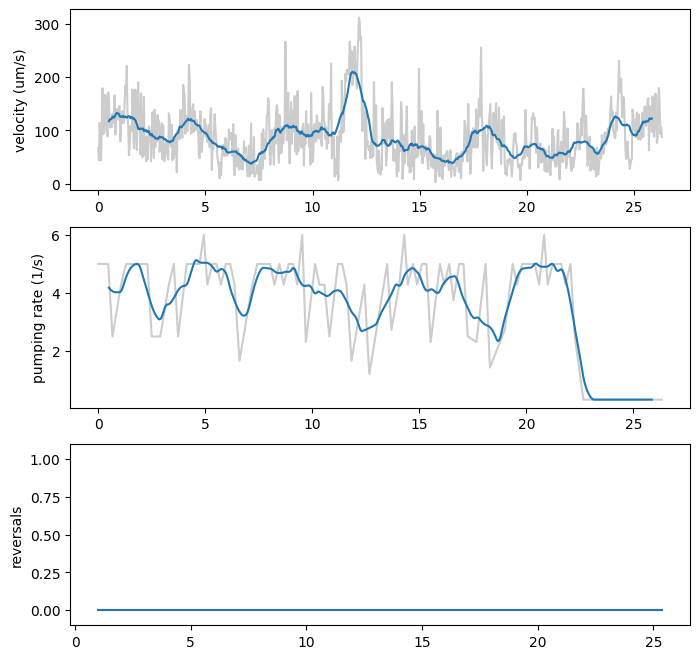

In [69]:
timeseries(traj);

### Population means

In [38]:
means = summary_stats(all_datasets)
print(isinstance(means, pd.DataFrame))
means.to_csv(os.path.join(outPath,"pumping_means.csv"))

True


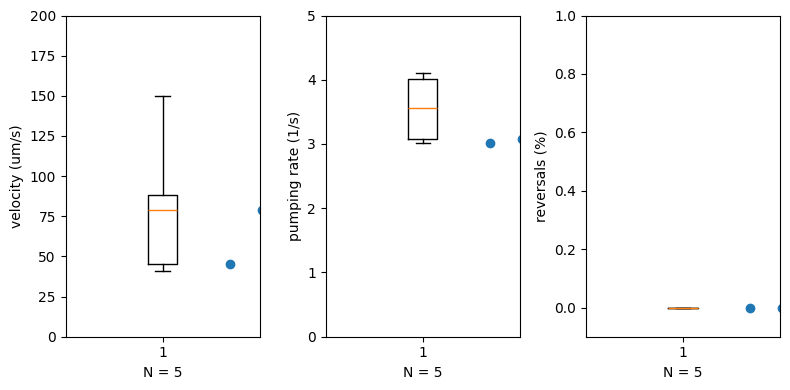

In [9]:
f, axes = plt.subplots(1,3, figsize=(8,4))
x = np.ones(len(means))-0.33*(2*np.random.rand(len(means))-2)
axes[0].boxplot(means['velocity'])
axes[0].scatter(x, means['velocity'])
axes[1].boxplot(means['rate'])
axes[1].scatter(x, means['rate'])
axes[2].boxplot(means['reversals_nose'])
axes[2].scatter(x, means['reversals_nose'])
plt.setp(axes, xlim=(0.5,1.5), xlabel = f'N = {len(means)}')
plt.setp(axes[0], ylabel = 'velocity (um/s)', ylim=(0,200))
plt.setp(axes[1], ylabel = 'pumping rate (1/s)', ylim = (0,5))
plt.setp(axes[2], ylabel = 'reversals (%)', ylim = (-0.1,1))

plt.tight_layout()

### Trajectories

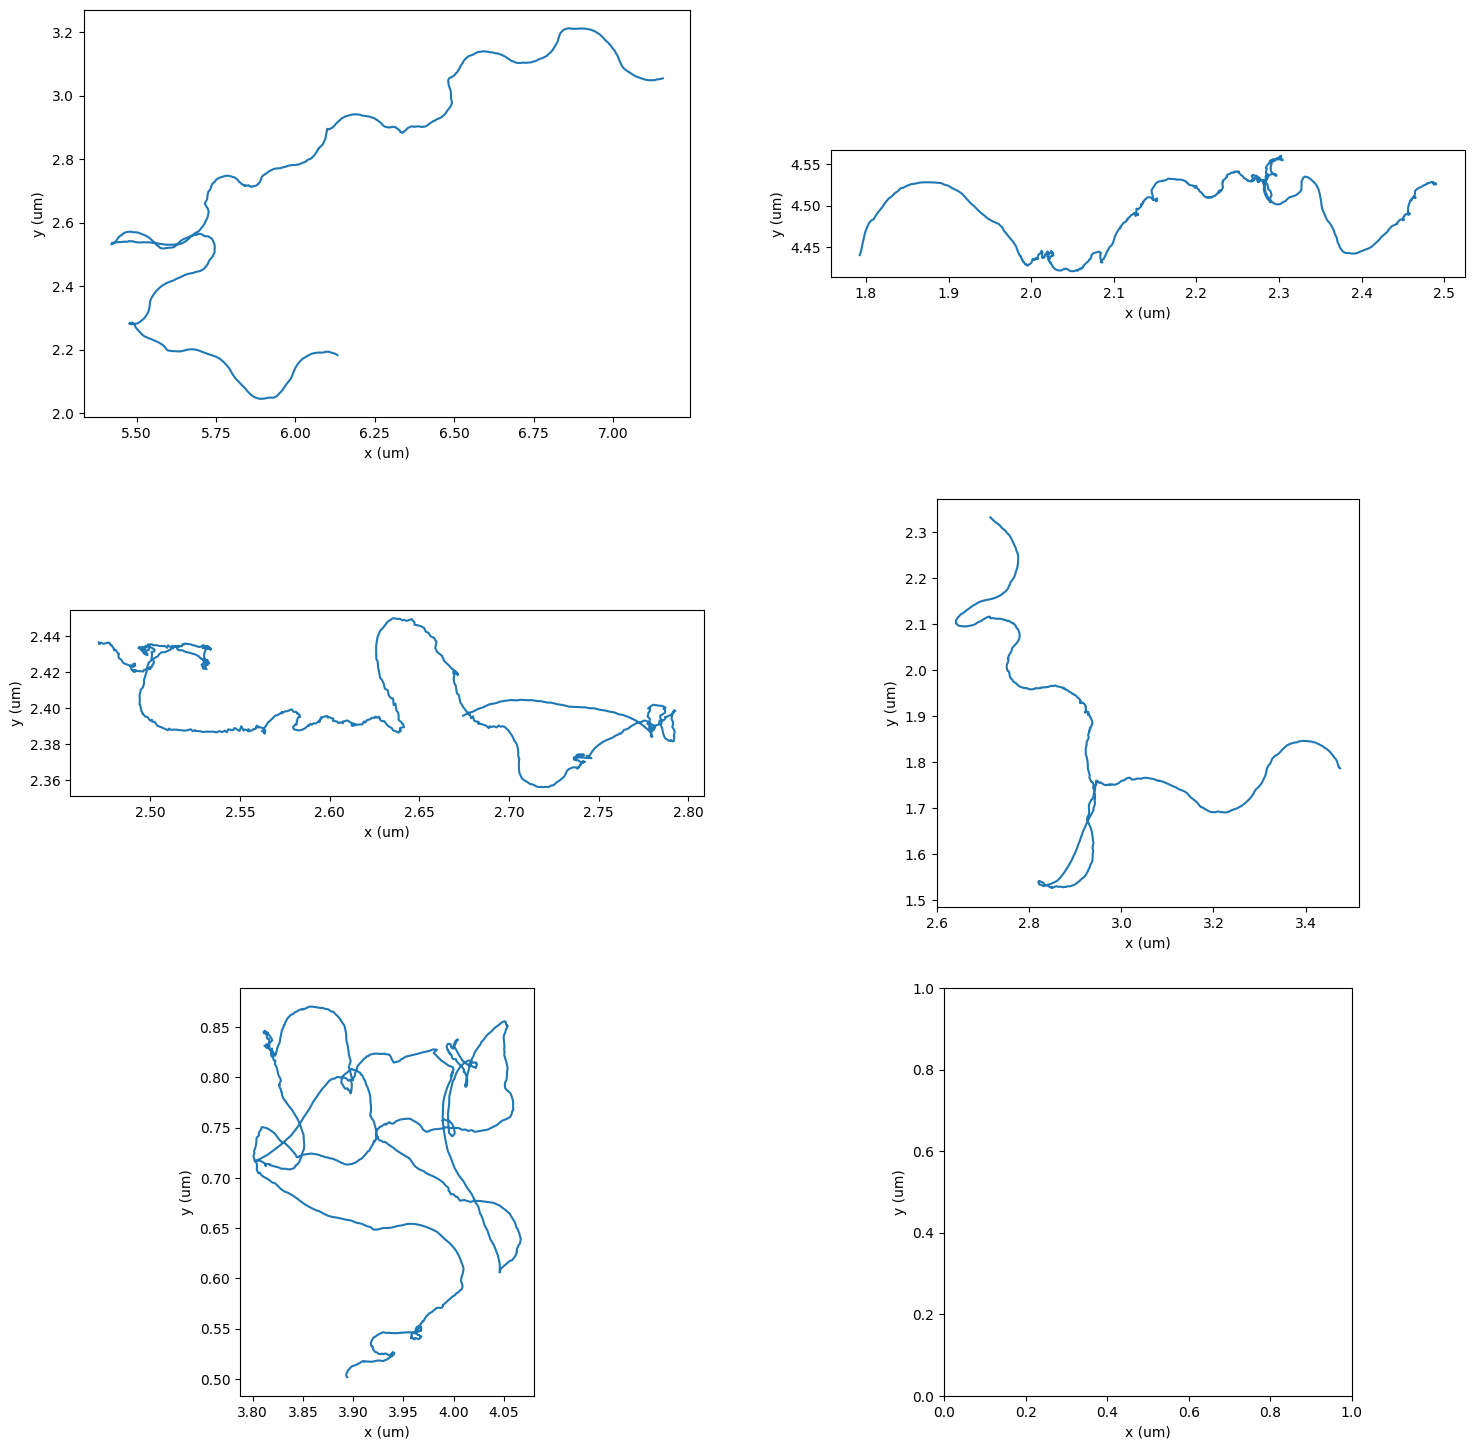

In [10]:
n = int(np.sqrt(len(all_datasets)))
f, axes = plt.subplots(n+1,n, figsize=(18,18))
axes = axes.ravel()
for ki, key in enumerate(all_datasets):
    axes[ki].plot(all_datasets[key].x_scaled/1000, all_datasets[key].y_scaled/1000)
plt.setp(axes, aspect=1, xlabel='x (um)', ylabel='y (um)');